<a href="https://colab.research.google.com/github/CoffeeTulip/CS39AA-Project/blob/main/ProjectPart2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# import all of the python modules/packages you'll need here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install datasets
!pip install nltk
!pip install sentencepiece
import datasets
from datasets import load_dataset
from datasets import DatasetDict
import nltk

nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

#Data Pre-processing

In [ ]:
# Convert dataset dict to dataset, seperate the splits from the whole so I can view it and alter it better
df = load_dataset("Amani27/massive_translation_dataset")
df = DatasetDict(df)

df_train = pd.DataFrame.from_dict(df['train'])
df_validation = pd.DataFrame.from_dict(df['validation'])
df_test = pd.DataFrame.from_dict(df['test'])
df = pd.concat([df_train, df_validation, df_test], ignore_index=True)

In [ ]:
columns_to_drop = ['id', 'split', 'de_DE', 'hi_IN', 'fr_FR', 'it_IT', 'ar_SA', 'nl_NL', 'ja_JP', 'pt_PT' ]
df = df.drop(columns = columns_to_drop)

In [ ]:
df.head()

,en_US,es_ES
0,wake me up at nine am on friday,despiértame a las nueve de la mañana el viernes
1,set an alarm for two hours from now,pon una alarma en dos horas desde ahora
2,olly quiet,olly silencio
3,stop,parar
4,olly pause for ten seconds,olly para por un minuto


#Text cleaning
*the text is pretty clean already... but just for practice :D*

In [ ]:
english_column = 'en_US'
spanish_column = 'es_ES'

# Tokenize English. The text dataset looked cleaned up already but just to be safe
english_text = ' '.join(df[english_column].astype(str).values)
english_tokens = word_tokenize(english_text.lower())

# Remove stopwords and punctuation
stop_words = set(stopwords.words('english') + list(string.punctuation))
english_filtered_tokens = [word for word in english_tokens if word.isalnum() and word not in stop_words]

# Get the most common words in English
english_common_words = Counter(english_filtered_tokens).most_common(10)

# Tokenize Spanish
spanish_text = ' '.join(df[spanish_column].astype(str).values)
spanish_tokens = word_tokenize(spanish_text.lower())  # Convert to lowercase for consistency

# Remove stopwords and punctuation
stop_words = set(stopwords.words('spanish') + list(string.punctuation))
spanish_filtered_tokens = [word for word in spanish_tokens if word.isalnum() and word not in stop_words]

# Get the most common words in Spanish
spanish_common_words = Counter(spanish_filtered_tokens).most_common(10)


# Display the results
print("Most common words in English:")
print(english_common_words)

print("\nMost common words in Spanish:")
print(spanish_common_words)

Most common words in English:
[('please', 1440), ('play', 1173), ('today', 849), ('list', 770), ('email', 718), ('new', 701), ('tell', 697), ('time', 650), ('set', 563), ('olly', 534)]

Most common words in Spanish:
[('favor', 1284), ('hoy', 865), ('lista', 859), ('correo', 859), ('mañana', 765), ('pon', 728), ('hora', 591), ('electrónico', 554), ('cuál', 542), ('puedes', 511)]


In [ ]:
from sklearn.model_selection import train_test_split

X = df['en_US'].values
y = df['es_ES'].values

# Assuming df is your DataFrame with columns 'en_US' and 'es_ES'
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

#Quick Model
##T5-Small Hugging Face Translator model

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("translation", model="t5-small")

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

#Model Class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length=128, is_test=False):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        # Encode input text
        inputs = self.tokenizer.encode_plus(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        if self.is_test:
            # For test set, only input_ids and attention_mask are needed
            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
            }
        else:
            # Encode target text for training
            targets = self.tokenizer.encode_plus(
                target_text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'labels': targets['input_ids'].squeeze()
            }

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

english_tokens = tokenizer(X_train, return_tensors='pt', padding=True, truncation=True)
valid_english_tokens = tokenizer(X_val, return_tensors='pt', padding=True, truncation=True)
test_english_tokens = tokenizer(X_test, return_tensors='pt', padding=True, truncation=True)

spanish_tokens = tokenizer(y_train, return_tensors='pt', padding=True, truncation=True)
valid_spanish_tokens = tokenizer(y_val, return_tensors='pt', padding=True, truncation=True)
test_spanish_tokens = tokenizer(y_test, return_tensors='pt', padding=True, truncation=True)

In [ ]:
test_dataset = CustomDataset(X_test, y_test, tokenizer, is_test=True)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#Model Training

In [ ]:
learning_rates = [.01, .001]
batch_sizes = [16, 32, 64]

num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = CustomDataset(X_train, y_train, tokenizer)
valid_dataset = CustomDataset(X_val, y_val, tokenizer)

train_losses = []
val_losses = []

for lr in learning_rates:
    for batch_size in batch_sizes:

      dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
      valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

      model = T5ForConditionalGeneration.from_pretrained('t5-small')
      optimizer = AdamW(model.parameters(), lr=lr)
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
      #------------------------------------------------------------------------------
      model.to(device)
      model.train()

      epoch_train_losses = []
      epoch_val_losses = []

      for epoch in range(num_epochs):
          # Training phase
          for batch in dataloader:
              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['labels'].to(device)

              outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
              loss = outputs.loss

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Validation phase
          model.eval()
          total_validation_loss = 0.0

          with torch.no_grad():
              for batch_val in valid_dataloader:
                  input_ids_val = batch_val['input_ids'].to(device)
                  attention_mask_val = batch_val['attention_mask'].to(device)
                  labels_val = batch_val['labels'].to(device)

                  outputs_val = model(input_ids_val, attention_mask=attention_mask_val, labels=labels_val)
                  loss_val = outputs_val.loss

                  total_validation_loss += loss_val.item()

          average_validation_loss = total_validation_loss / len(valid_dataloader)

          # Store losses for the current epoch
          epoch_train_losses.append(loss.item())
          epoch_val_losses.append(average_validation_loss)

          print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {average_validation_loss}')

          # Set the model back to training mode
          model.train()

      # Append the final losses for this combination
      train_losses.append(epoch_train_losses)
      val_losses.append(epoch_val_losses)

# Save the trained model
model.save_pretrained('/content/gdrive/My Drive/Colab Notebooks/CS39AA/En_ES_Dataframe')
tokenizer.save_pretrained('/content/gdrive/My Drive/Colab Notebooks/CS39AA/En_ES_Dataframe_tokens')

# For memory problem when fine tuning:
# Could add gradient clipping
# Could add gradient accumulation

#Load from saved model
i added this cell for testing purposes

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Define the paths where you saved the model and tokenizer
model_path = '/content/gdrive/My Drive/Colab Notebooks/CS39AA/En_ES_Dataframe'
tokenizer_path = '/content/gdrive/My Drive/Colab Notebooks/CS39AA/En_ES_Dataframe_tokens'

# Load the model
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

# Print a table
table_data = []
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        table_data.append([f'LR={lr}, Batch={batch_size}', train_losses[i * len(batch_sizes) + j][-1], val_losses[i * len(batch_sizes) + j][-1]])

headers = ['Combination', 'Train Loss', 'Validation Loss']
table = tabulate(table_data, headers, tablefmt='grid', numalign="center", stralign="center")

print("Loss Values for Each Combination:")
print(table)

Loss Values for Each Combination:
+--------------------+--------------+-------------------+
|    Combination     |  Train Loss  |  Validation Loss  |
+====================+==============+===================+
| LR=0.01, Batch=16  |   0.683393   |     0.522851      |
+--------------------+--------------+-------------------+
| LR=0.01, Batch=32  |   0.291594   |     0.259436      |
+--------------------+--------------+-------------------+
| LR=0.01, Batch=64  |   0.354585   |     0.335522      |
+--------------------+--------------+-------------------+
| LR=0.001, Batch=16 |   0.130829   |     0.155418      |
+--------------------+--------------+-------------------+
| LR=0.001, Batch=32 |   0.231616   |     0.191537      |
+--------------------+--------------+-------------------+
| LR=0.001, Batch=64 |   0.27282    |     0.236568      |
+--------------------+--------------+-------------------+


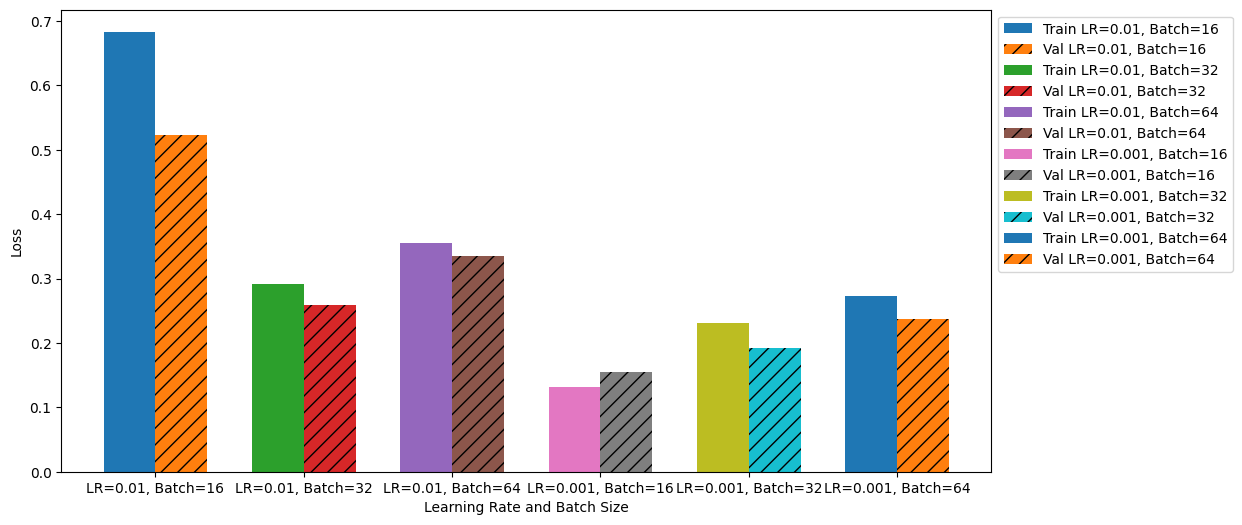

In [ ]:
# Bar graph
width = 0.35
x = np.arange(len(learning_rates) * len(batch_sizes))

fig, ax = plt.subplots(figsize=(12, 6))
for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        train_bar = ax.bar(x[i * len(batch_sizes) + j] - width/2, train_losses[i * len(batch_sizes) + j][-1], width, label=f'Train LR={lr}, Batch={batch_size}')
        val_bar = ax.bar(x[i * len(batch_sizes) + j] + width/2, val_losses[i * len(batch_sizes) + j][-1], width, label=f'Val LR={lr}, Batch={batch_size}', hatch='//')

ax.set_xticks(x)
ax.set_xticklabels([f'LR={lr}, Batch={batch_size}' for lr in learning_rates for batch_size in batch_sizes])
ax.set_xlabel('Learning Rate and Batch Size')
ax.set_ylabel('Loss')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
input_text = "how are you?"
input_tokens = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    model.eval()
    input_ids = input_tokens['input_ids'].to(device)
    attention_mask = input_tokens['attention_mask'].to(device)

    model = model.to(device)

    # Generate translations
    translation_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=50, num_beams=4)

# Decode the generated translation
translation_text = tokenizer.decode(translation_ids[0], skip_special_tokens=True)
print("Input Text:", input_text)
print("Translated Text:", translation_text)

Input Text: hi?
Translated Text: aado el correo electrónico


In [ ]:
!pip install tqdm nltk sacrebleu
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
import torch

#BLEU Score
BLEU stands for billingual evaluation understudy, and is a score between 0 and 1. BLEU score is a metric based on the idea that the closer a generated text is to the human generated target, text the better. Its important to note though, that with language and scentences the quantiative data that is being assesed against the model is human generated, so a scentence can have multiple completley correct translations.

With that, the BLEU score will be a score between 0 and 1, with near 0 or 1 scores being not ideal.

In [ ]:
# Switch model to evaluation mode
model.eval()

# Lists to store references and translations
references = []
translations = []

# Iterate over test batches
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Translating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Generate translations
        translation_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=50, num_beams=4)

        # Decode the generated translation
        generated_text = tokenizer.decode(translation_ids[0], skip_special_tokens=True)

        # Fetch corresponding target sequences from the dataset
        if 'labels' in batch:
            # Training set
            target_sequence = tokenizer.decode(batch['labels'][0], skip_special_tokens=True)
        else:
            # Test set
            target_sequence = tokenizer.decode(input_ids[0], skip_special_tokens=True)

        # Collect references and translations for evaluation
        references.append([target_sequence])
        translations.append(generated_text)

# Calculate BLEU score
from nltk.translate.bleu_score import corpus_bleu

# Convert references into the format expected by corpus_bleu
references = [[reference[0].split()] for reference in references]

# Tokenize generated translations for BLEU score calculation
generated_tokens = [translation.split() for translation in translations]

# Calculate BLEU score
bleu_score = corpus_bleu(references, generated_tokens)
print("BLEU Score:", bleu_score)

Translating: 100%|██████████| 52/52 [01:21<00:00,  1.56s/it]

BLEU Score: 0.018476796670118017
